In [210]:
import os
import pandas as pd
pd.set_option('max_rows',None)
import json
import numpy as np
from datetime import *
import time as t

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer,mean_squared_error,mean_absolute_error,r2_score
from sklearn.svm import SVR

from xgboost import XGBRegressor
import lightgbm as lgb

In [211]:
data = pd.read_csv('data.csv',delimiter=';')
data.rename(columns = {'Date':'date'},inplace = True)
data

,date,installs,spend_facebook,spend_google,promotion
0,1-1-2019,1667,1406.0,NaN,Yes
1,1-2-2019,1889,1197.0,NaN,Yes
2,1-3-2019,1462,1090.0,NaN,Yes
3,1-4-2019,1218,1434.0,NaN,Yes
4,1-5-2019,1721,1449.0,NaN,Yes
5,1-6-2019,1696,1475.0,NaN,Yes
6,1-7-2019,1528,1254.0,NaN,Yes
7,1-8-2019,1246,1223.0,NaN,Yes
8,1-9-2019,1248,1414.0,NaN,Yes
9,1-10-2019,1150,1383.0,NaN,Yes


In [212]:
def add_lags(df,n):
    for i in range(n):
        a = i+1
        df['install_lag{}'.format(a)] = df['installs'].shift(a)
        df['install_ewm{}'.format(a)] = df['installs'].ewm(a).mean()
        
    return df

def powerlist(start, base, times):
    return [start * base ** i for i in range(0, times, 1)]
        

def preprocess(df):
    df['date'] = df['date'].apply(lambda x : datetime.strptime(x, "%m-%d-%Y"))

    df['promotion'] = np.where(df['promotion'].isna(),0,1)

    df['month'] = df.date.dt.month.astype('category')
    df['week'] = df.date.dt.weekofyear.astype('category')
    df['year'] = df.date.dt.year.astype('category')
    df['weekday'] = df.date.dt.weekday.astype('category')

    df['fb_flag'] = np.where(df['spend_facebook'].isna(),0,1)
    df['gl_flag'] = np.where(df['spend_google'].isna(),0,1)

    df['spend_facebook'].fillna(0,inplace = True)
    df['spend_google'].fillna(0,inplace = True)

    gl_scaler = MinMaxScaler().fit(df['spend_google'].values.reshape(-1, 1))
    fb_scaler = MinMaxScaler().fit(df['spend_facebook'].values.reshape(-1, 1))
    
    df.set_index('date',inplace = True)
    
    train = df[df['type'] == 'train'].drop('type',1)
    test = df[df['type'] == 'test'].drop('type',1)
    
    train = pd.get_dummies(train)
    test = pd.get_dummies(test)
    
    # df = add_lags(df,n)
    
    
    
    return train,test

In [213]:
def define_test_df(dt,period,fb,gl):
    name = pd.DataFrame(pd.date_range(dt,periods = period,freq='1D',closed = 'right'),columns = ['date'])
    name['date'] = name['date'].apply(lambda x : datetime.strftime(x, "%m-%d-%Y")) 
    name['installs'] = np.nan
    name['spend_facebook'] = fb
    name['spend_google'] = gl
    name['promotion'] = np.nan

    return name

In [214]:

dt = datetime.strptime(data.date.tail(1).iloc[-1], "%m-%d-%Y")
test1 = define_test_df(dt,7*4,500,1000)
data['type'] = 'train'
test1['type'] = 'test'
data = pd.concat([data,test1])

train,test = preprocess(data)
# add_lags(data,2)



In [215]:

from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(train.drop('installs',1), train['installs'], test_size=0.33, random_state=42,shuffle=False)

In [219]:
results = pd.DataFrame(pd.date_range(dt,periods = 7*4,freq='1D',closed = 'right'),columns = ['date'])

In [147]:


scorer = make_scorer(r2_score)
tree_parameters = [{'min_samples_leaf': list(range(2, 10, 1)),
                    'cri`terion': ['mae', 'mse'],
                    'random_state': [1]}]

tree_grid = GridSearchCV(estimator=DecisionTreeRegressor(),
                         param_grid=tree_parameters,
                         scoring=scorer, cv=5,
                         n_jobs=-1, iid=False)

tree_grid_result = tree_grid.fit(X_train, y_train)
best_tree_parameters = tree_grid_result.best_params_
tree_score = tree_grid_result.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [155]:
pd.DataFrame(tree_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_leaf,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.060520,0.009735,0.004600,8.009332e-04,mae,2,1,"{'criterion': 'mae', 'min_samples_leaf': 2, 'r...",-3.294359,-0.008807,-1.515017,-0.410852,-2.009865,-1.447780,1.172704,8
1,0.058998,0.010276,0.004202,4.000725e-04,mae,3,1,"{'criterion': 'mae', 'min_samples_leaf': 3, 'r...",-2.962573,-0.044815,-1.111227,-0.401705,-2.105881,-1.325240,1.079673,3
2,0.056400,0.012534,0.005000,8.944233e-04,mae,4,1,"{'criterion': 'mae', 'min_samples_leaf': 4, 'r...",-2.792768,0.003052,-0.793834,-0.534813,-1.429516,-1.109576,0.959529,1
3,0.052003,0.011779,0.003396,4.931816e-04,mae,5,1,"{'criterion': 'mae', 'min_samples_leaf': 5, 'r...",-2.796803,0.020919,-0.842384,-0.545523,-1.478962,-1.128550,0.964256,2
4,0.050798,0.013194,0.003802,4.001930e-04,mae,6,1,"{'criterion': 'mae', 'min_samples_leaf': 6, 'r...",-2.740348,0.016284,-1.248247,-0.532844,-2.458545,-1.392740,1.067486,6
5,0.050002,0.005961,0.004991,1.259480e-03,mae,7,1,"{'criterion': 'mae', 'min_samples_leaf': 7, 'r...",-2.868266,0.004882,-1.248247,-0.532844,-2.224207,-1.373736,1.056443,5
6,0.032800,0.009743,0.003803,4.001437e-04,mae,8,1,"{'criterion': 'mae', 'min_samples_leaf': 8, 'r...",-3.250386,-0.106082,-1.510056,-0.692381,-2.231636,-1.558108,1.111541,10
7,0.027996,0.002609,0.004402,8.041222e-04,mae,9,1,"{'criterion': 'mae', 'min_samples_leaf': 9, 'r...",-3.302879,-0.094609,-1.529764,-0.631876,-1.444066,-1.400639,1.089384,7
8,0.009198,0.000748,0.003802,4.006378e-04,mse,2,1,"{'criterion': 'mse', 'min_samples_leaf': 2, 'r...",-3.855958,0.034566,-1.476567,-2.715957,-2.008225,-2.004428,1.293877,16
9,0.008998,0.000633,0.003681,5.755966e-04,mse,3,1,"{'criterion': 'mse', 'min_samples_leaf': 3, 'r...",-3.573421,0.008375,-1.031768,-2.889907,-1.321938,-1.761732,1.297269,14


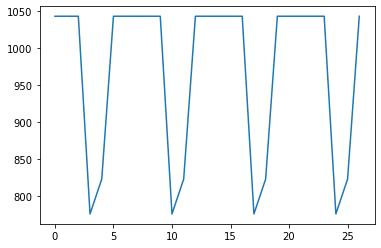

In [220]:

results['dtr'] = tree_grid.best_estimator_.predict(test.drop('installs',1))
results['dtr'].plot()


In [151]:
forest_parameters = [{'n_estimators': powerlist(50, 2, 4),
                      'min_samples_leaf': list(range(2, 10, 1)),
                      'criterion': ['mae', 'mse'],
                      'random_state': [1], 'n_jobs': [-1]}]
forest_grid = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=forest_parameters,
                           scoring=scorer, cv=5,
                           n_jobs=-1, iid=False)
forest_grid_result = forest_grid.fit(X_train, y_train)
best_forest_parameters = forest_grid_result.best_params_
forest_score = forest_grid_result.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [156]:
pd.DataFrame(forest_grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_leaf,param_n_estimators,param_n_jobs,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.677926,0.208130,0.988494,0.700589,mae,2,50,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 2, 'n...",0.476879,0.059353,-1.715992,0.127036,-1.205084,-0.451562,0.851398,4
1,2.091318,0.354852,1.541867,0.329139,mae,2,100,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 2, 'n...",0.252168,0.041325,-1.582942,0.084674,-1.188319,-0.478619,0.754307,7
2,4.114885,0.494657,2.247120,1.350216,mae,2,200,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 2, 'n...",0.101915,-0.015581,-1.534531,0.097236,-1.249170,-0.520026,0.718771,12
3,8.005403,0.395649,0.999352,0.392479,mae,2,400,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 2, 'n...",-0.054388,-0.004692,-1.451556,0.120017,-1.243607,-0.526845,0.675741,13
4,3.992779,1.646256,2.411769,1.509290,mae,3,50,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 3, 'n...",0.509748,0.087881,-1.425797,0.001135,-1.320893,-0.429585,0.790254,2
5,2.153033,0.763784,1.516001,0.787550,mae,3,100,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 3, 'n...",0.301296,0.055671,-1.347489,0.018578,-1.252639,-0.444917,0.705592,3
6,3.484364,0.598333,2.104647,0.778802,mae,3,200,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 3, 'n...",0.134463,0.000174,-1.400780,0.046931,-1.207405,-0.485323,0.672696,8
7,7.490646,0.609774,1.551624,0.514880,mae,3,400,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 3, 'n...",-0.041311,0.014364,-1.311570,0.081441,-1.217052,-0.494826,0.630193,9
8,3.755196,0.064630,1.203030,0.329557,mae,4,50,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 4, 'n...",0.516521,0.072132,-1.354634,-0.001224,-1.316698,-0.416781,0.770999,1
9,2.076762,0.251591,1.251763,0.449359,mae,4,100,-1,1,"{'criterion': 'mae', 'min_samples_leaf': 4, 'n...",0.289291,0.031403,-1.415441,0.000470,-1.266731,-0.472202,0.718037,6


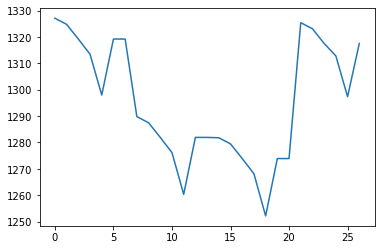

In [221]:
results['rfr'] = forest_grid_result.best_estimator_.predict(test.drop('installs',1))
results['rfr'].plot()


In [163]:

svr_parameters = [{'kernel': ['linear', 'rbf'],
                   'C': powerlist(0.1, 2, 10),
                   'epsilon': powerlist(0.01, 2, 10),
                   'gamma': ['scale']},
                  {'kernel': ['poly'],
                   'degree': list(range(2, 5, 1)),
                   'C': powerlist(0.1, 2, 10),
                   'epsilon': powerlist(0.01, 2, 10),
                   'gamma': ['scale']}]
svr_grid = GridSearchCV(estimator=SVR(),
                        param_grid=svr_parameters,
                        scoring=scorer, cv=5,
                        n_jobs=-1, iid=False)
svr_grid_result = svr_grid.fit(X_train, y_train)
best_svr_parameters = svr_grid_result.best_params_
svr_score = svr_grid_result.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


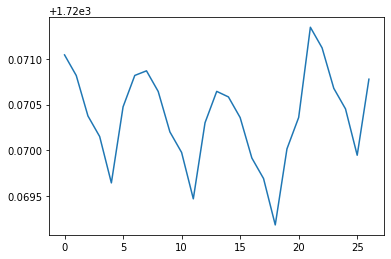

In [222]:
results['svr'] = svr_grid.best_estimator_.predict(test.drop('installs',1))
results['svr'].plot()

In [187]:
 XGBRegressor(n_estimators=500, learning_rate= 0.05, gamma=2, subsample=0.75, colsample_bytree=1, max_depth=6, verbose = 0)
xgb_parameters = [{'n_estimators': powerlist(50, 2, 4),
                   'learning_rate': powerlist(.05, 2, 6),
                   'gamma': powerlist(1, 1.5, 4),
                   'max_depth':np.arange(1,8,2)
                  }]
xgb_grid = GridSearchCV(estimator=XGBRegressor(),
                        param_grid=xgb_parameters,
                        scoring=scorer, cv=5,
                        n_jobs=-1, iid=False)

xgb_grid_result = xgb_grid.fit(X_train, y_train)
best_xgb_parameters = xgb_grid_result.best_params_
xgb_score = xgb_grid_result.best_score_

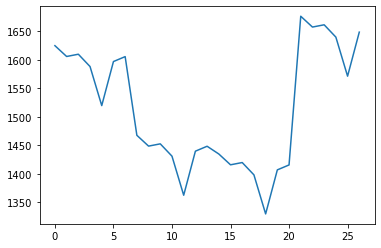

In [223]:
results['xgb'] = xgb_grid.best_estimator_.predict(test.drop('installs',1))
results['xgb'].plot()

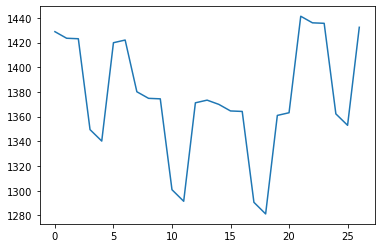

In [224]:
results['avg'] = results.mean(axis=1)
results['avg'].plot()

In [225]:
results

,date,dtr,rfr,svr,xgb,avg
0,2021-03-01,1043.0,1327.07,1720.071044,1625.048706,1428.797437
1,2021-03-02,1043.0,1324.75,1720.070818,1606.054443,1423.468815
2,2021-03-03,1043.0,1319.19,1720.070376,1610.030518,1423.072723
3,2021-03-04,776.0,1313.43,1720.070151,1588.392822,1349.473243
4,2021-03-05,823.0,1297.97,1720.069644,1519.829224,1340.217217
5,2021-03-06,1043.0,1319.19,1720.070476,1597.154541,1419.853754
6,2021-03-07,1043.0,1319.19,1720.070819,1605.814697,1422.018879
7,2021-03-08,1043.0,1289.79,1720.070870,1467.677002,1380.134468
8,2021-03-09,1043.0,1287.47,1720.070644,1448.682739,1374.805846
9,2021-03-10,1043.0,1281.91,1720.070201,1452.658813,1374.409754


In [231]:
final = train[['installs']]
final['type'] = 'Train'
final = pd.concat([final,test[['installs']]])

final.loc[final['installs'].isna(),'type'] = 'Test'
final.loc[final['installs'].isna(),'installs'] = results['dtr'].values

<ipython-input-231-16a5f51e021d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['type'] = 'Train'


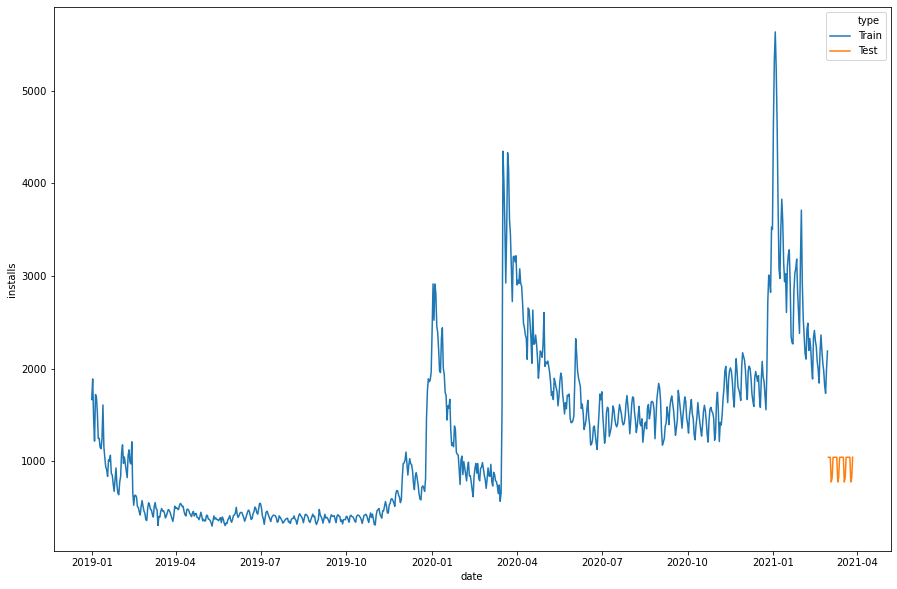

In [232]:
plt.figure(figsize=(15,10))
sns.lineplot(final.index,final['installs'],hue=final['type'])

In [177]:
 powerlist(1, 1.5, 4)

[1.0, 1.5, 2.25, 3.375]

In [181]:
np.arange(1,8,2)

array([1, 3, 5, 7])